In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,SpatialDropout1D, GlobalMaxPooling1D, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

###tokenization and sequencing:

- tokenization: uses tf tokenizer to create a vocabulary

- sequence conversion: clean sequence -> sequence corresponding integer IDs, base on the vocabulary

- padding: pad all sequence with zeros until the reach maximum length, ensure all input stays the same

In [ ]:
tokens = set()
for t in clean_text:
    tokens.update(t.split())

print("Manual vocab size (sample):", len(tokens))
print(list(tokens)[:20])


Manual vocab size (sample): 20190
['fort', 'sew', 'tanning', 'inxs', 'sloppy', 'fangoria', 'cece', 'nvd', 'cuute', 'puffy', 'neurasthenic', 'beat', 'wh', 'ajc', 'turgid', 'poll', 'rrod', 'circuit', 'unconvincing', 'tax']


In [ ]:
max_word = 0
for text in clean_text:
  max_word = np.maximum(max_word,len(text))
print(max_word)

252


In [ ]:
# -------------------------
# 1. Create and fit Tokenizer
# -------------------------
vocab_size = 12_500   # max number of words to keep
oov_token = "<OOV>"  # token for unknown words
stop_words='english'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(clean_text)

# View the vocabulary (optional)
print("vocabulary:",len(tokenizer.word_index))
print(tokenizer.word_index)

# -------------------------
# 2. Convert texts → integer sequences
# -------------------------
sequences = tokenizer.texts_to_sequences(clean_text)
print("\nsequences:\n",sequences[:3])

# -------------------------
# 3. Pad sequences to same length
# -------------------------
max_length = 30  # set max token length (adjust as needed)

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
print("\npadded sequences:\n",padded_sequences[:3])


vocabulary: 20191
{'<OOV>': 1, 'the': 2, 'a': 3, ...

sequences:
 [[3, 5708, 121, 7, 309, 3221, 105, 10277, 9, 1124, 7, 2, 2120, 7, 10, 677, 29], ...]]

padded sequences:
 [[    3  5708   121     7   309  3221   105 10277     9  1124     7     2
   2120     7    10   677    29     0     0     0     0     0     0     0
      0     0     0     0     0     0]


###split(run)

[7593. 7597. 7684.]


[]

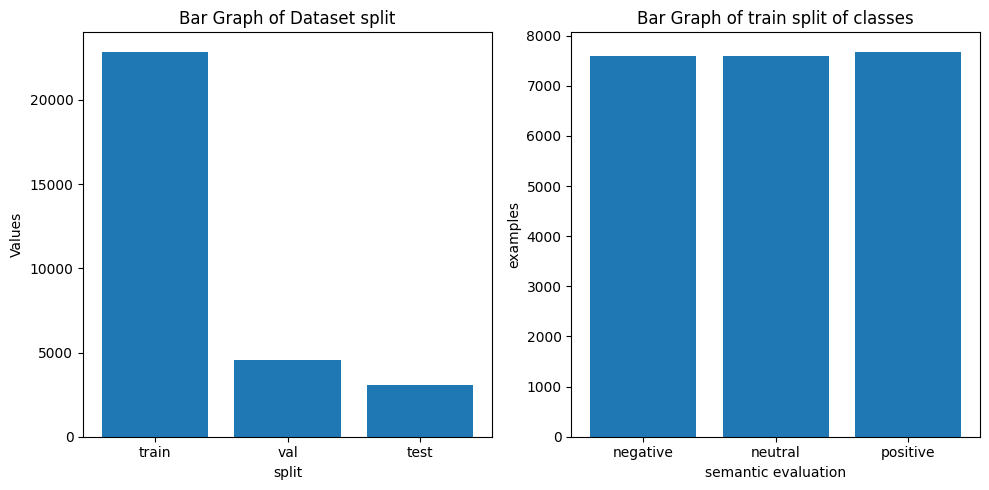

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((padded_sequences, y))
dataset = dataset.shuffle(buffer_size=len(padded_sequences), reshuffle_each_iteration=False)

N = len(padded_sequences)
train_size = int(0.75 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds = dataset.take(train_size)
val_ds   = dataset.skip(train_size).take(val_size)
test_ds  = dataset.skip(train_size + val_size)

train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

X_values = ("train","val","test")
y_values = (train_size,val_size,test_size)

fig,axarr = plt.subplots(1,2,figsize=(10,5))

axarr[0].bar(X_values,y_values)

axarr[0].set_xlabel('split')
axarr[0].set_ylabel('Values')
axarr[0].set_title('Bar Graph of Dataset split')

counter = np.zeros(len(classes))
for _,y_batched in train_ds:
  for y_ in y_batched:
    counter[int(y_*(len(classes)-1))]+=1
print(counter)
axarr[1].bar(classes,counter)
axarr[1].set_xlabel('semantic evaluation')
axarr[1].set_ylabel('examples')
axarr[1].set_title('Bar Graph of train split of classes')

plt.tight_layout()
plt.plot()

###model

input layer:

takes padded integer sequence

embedding layer:

convert integer sequence into dence words vectors

recurrect layer(LSTM/GRU):

core of the model

output layer(Dense):

dense layer with as many neuron as output(positive,negative,netural)

###features engeneering(words embedding):

each word is mapped to a dense(continious vector - 100 dimentions), where similar words has similar values

methods:

1) keras embedding layer, the networks learn the vectors from stratch during training, with optimizing to my task

2) use pretrain embedding(Word2Vec/GloVe) and loading them into the embeding layer



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        scores = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(scores, axis=1)
        return tf.reduce_sum(inputs * weights, axis=1)

class WordDropout(tf.keras.layers.Layer):
    def __init__(self, rate):
        super().__init__()
        self.rate = rate

    def call(self, x, training=None):
        if training:
            mask = tf.random.uniform(tf.shape(x)) > self.rate
            return x * tf.cast(mask, x.dtype)
        return x

In [ ]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 128, input_length=30, trainable=True),
    SpatialDropout1D(0.2),

    Bidirectional(LSTM(64, return_sequences=True)),
    Attention(),
    LayerNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
]
